<a href="https://colab.research.google.com/github/Defiduke/nsf-player/blob/master/NESMusicmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Number of files: 1269
CLEANED_DATA\149 Ligar's Castle.mid
Number of instruments: 3
Instrument name: Synth Strings 1
0: pitch=36, note_name=C2, duration=1.3333
1: pitch=43, note_name=G2, duration=1.3333
2: pitch=44, note_name=G#2, duration=1.3333
3: pitch=38, note_name=D2, duration=1.3333
4: pitch=36, note_name=C2, duration=1.3333
5: pitch=43, note_name=G2, duration=1.3333
6: pitch=44, note_name=G#2, duration=1.3333
7: pitch=38, note_name=D2, duration=1.3333
8: pitch=36, note_name=C2, duration=1.3333
9: pitch=43, note_name=G2, duration=1.3333
10: pitch=44, note_name=G#2, duration=1.3333
11: pitch=48, note_name=C3, duration=1.3333
12: pitch=46, note_name=A#2, duration=1.3333
13: pitch=44, note_name=G#2, duration=1.3333
14: pitch=43, note_name=G2, duration=2.6667
15: pitch=41, note_name=F2, duration=1.3333
16: pitch=43, note_name=G2, duration=1.3333
17: pitch=44, note_name=G#2, duration=2.6667
18: pitch=39, note_name=D#2, duration=1.3333
19: pitch=41, note_name=F2, duration=1.3333
20: pit

C:\Python310\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of notes parsed: 27729
TensorSpec(shape=(3,), dtype=tf.float64, name=None)
432/432 [==============================] - 14s 25ms/step - loss: 6.0311 - duration_loss: 0.6721 - pitch_loss: 4.8507 - step_loss: 0.5082


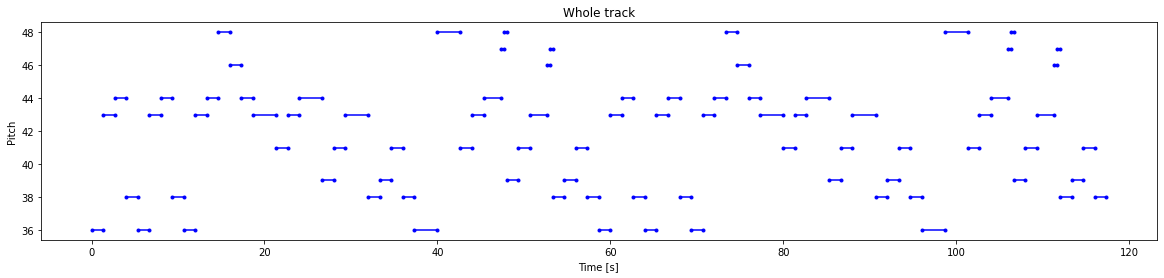

In [9]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import os
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
import random

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

seed = 250
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 44000

data_dir = pathlib.Path('CLEANED_DATA')

if not data_dir.exists():print("Directory does not exist")

filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))


sample_file = filenames[300]
print(sample_file)
 
pm = pretty_midi.PrettyMIDI(sample_file)

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=15):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)  


print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)


for i, note in enumerate(instrument.notes[:30]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')
  
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
  notes = collections.defaultdict(list)



  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

raw_notes = midi_to_notes(sample_file)

raw_notes.head()


get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:30]

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

plot_piano_roll(raw_notes)

def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  instrument_name= pretty_midi.program_to_instrument_name(instrument_name)
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

num_files = 120

all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)
  
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
print(notes_ds.element_spec)

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

train_ds.element_spec


def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

input_shape = (seq_length, 3)
learning_rate = 0.001

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)







model.compile(
    loss=loss,
    loss_weights={
        'pitch': 1.0,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)



losses = model.evaluate(train_ds, return_dict=True)
losses

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]
# hide 


In [10]:
display_audio(pm)

Epoch 1/250
432/432 [==============================] - 23s 51ms/step - loss: 4.5318 - duration_loss: 0.0613 - pitch_loss: 4.0138 - step_loss: 0.4567
Epoch 2/250
432/432 [==============================] - 21s 48ms/step - loss: 3.7593 - duration_loss: 0.0459 - pitch_loss: 3.2845 - step_loss: 0.4290
Epoch 3/250
432/432 [==============================] - 20s 47ms/step - loss: 3.5465 - duration_loss: 0.0444 - pitch_loss: 3.0835 - step_loss: 0.4186
Epoch 4/250
432/432 [==============================] - 20s 47ms/step - loss: 3.4207 - duration_loss: 0.0439 - pitch_loss: 2.9628 - step_loss: 0.4140
Epoch 5/250
432/432 [==============================] - 16s 38ms/step - loss: 3.3208 - duration_loss: 0.0437 - pitch_loss: 2.8667 - step_loss: 0.4104
Epoch 6/250
432/432 [==============================] - 16s 36ms/step - loss: 3.2451 - duration_loss: 0.0438 - pitch_loss: 2.7922 - step_loss: 0.4092
Epoch 7/250
432/432 [==============================] - 15s 36ms/step - loss: 3.1710 - duration_loss: 0.044

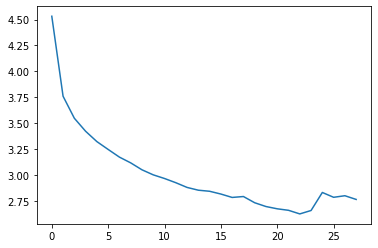

CPU times: total: 38min 20s
Wall time: 8min 41s


In [11]:
%%time
epochs = 250

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [38]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)
  #duration = random.random()
  return int(pitch), float(step), float(duration)

temperature = 1
num_predictions = 100

sample_file=filenames[random.randint(0, 1284)]
raw_notes = midi_to_notes(sample_file)


sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start =  step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
generated_notes, columns=(*key_order, 'start', 'end'))
generated_notes.head(20)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes2 = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start =  step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes2.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes2 = pd.DataFrame(
generated_notes2, columns=(*key_order, 'start', 'end'))
generated_notes2.head(10)

input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))


generated_notes3 = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start =  step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes3.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes3 = pd.DataFrame(
generated_notes3, columns=(*key_order, 'start', 'end'))
generated_notes3.head(30)

,pitch,step,duration,start,end
0,82,0.325121,0.119598,0.325121,0.444719
1,100,0.663941,0.486119,0.663941,1.150060
2,89,0.822294,0.547947,0.822294,1.370240
3,78,0.834517,0.577776,0.834517,1.412293
4,79,0.796565,0.581822,0.796565,1.378387
5,81,0.739604,0.569467,0.739604,1.309070
6,81,0.704407,0.561251,0.704407,1.265658
7,81,0.673501,0.557569,0.673501,1.231070
8,79,0.650713,0.551893,0.650713,1.202606
9,104,0.634756,0.531841,0.634756,1.166597


In [40]:
out_file = 'output.mid'
out_file2 = 'output2.mid'
out_file3 = 'output3.mid'


pmt = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=random.randint(4,36))

pmt.write(out_file)

pmt2 = notes_to_midi(
    generated_notes2, out_file=out_file2, instrument_name=random.randint(4,36))
pmt2.write(out_file2)

pmt3 = notes_to_midi(
    generated_notes3, out_file=out_file3, instrument_name=random.randint(80,128))
pmt3.write(out_file3)

#pmt=pretty_midi.PrettyMIDI(pmt)


#print(pmt.instruments[0])

#plot_piano_roll(generated_notes)
display_audio(pmt)
display_audio(pmt2)



In [41]:
import mido

mid1 = mido.MidiFile('output.mid')
mid2 = mido.MidiFile('output2.mid')
mid3 = mido.MidiFile('output3.mid')

merged_mid = mido.MidiFile()
# Copy time resolution. (If mid1 and mid2 have different
# ticks_per_beat you will get timing problems.)
merged_mid.ticks_per_beat=mid1.ticks_per_beat

merged_mid.tracks = mid1.tracks + mid2.tracks + mid3.tracks
merged_mid.save('merged.mid')



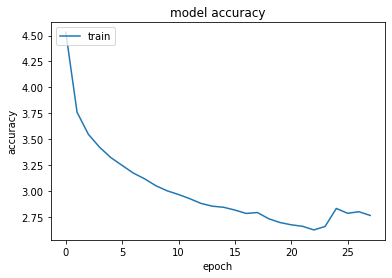

In [15]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [42]:
"""Synthesize a MIDI file, chiptunes-style! (using pure numpy and scipy)
Includes functions for synthesizing different drum types, bass instruments, and
all other instruments.  Also for auto-arpeggiating chords.
"""

import numpy as np
import scipy.signal
import scipy.io.wavfile
import pretty_midi
import argparse
import sys


def tonal(fs, length, frequency, nonlinearity=1.):
    '''
    Synthesize a tonal drum.
    Parameters
    ----------
    fs : int
        Sampling frequency
    length : int
        Length, in samples, of drum sound
    frequency : float
        Frequency, in Hz, of the drum
    nonlinearity : float
        Gain to apply for nonlinearity, default 1.
    Returns
    -------
    drum_data : np.ndarray
        Synthesized drum data
    '''
    # Amplitude envelope, decaying exponential
    amp_envelope = np.exp(np.linspace(0, -10, length))
    # Pitch envelope, starting with linear decay
    pitch_envelope = np.linspace(1.0, .99, length)
    # Also a quick exponential drop at the beginning for a click
    pitch_envelope *= 100*np.exp(np.linspace(0, -100*frequency, length)) + 1
    # Generate tone
    drum_data = amp_envelope*np.sin(
        2*np.pi*frequency*pitch_envelope*np.arange(length)/float(fs))
    # Filter with leaky integrator with 3db point ~= note frequency
    alpha = 1 - np.exp(-2*np.pi*(frequency)/float(fs))
    drum_data = scipy.signal.lfilter([alpha], [1, alpha - 1], drum_data)
    # Apply nonlinearity
    drum_data = np.tanh(nonlinearity*drum_data)
    return drum_data


def noise(length):
    '''
    Synthesize a noise drum.
    Parameters
    ----------
    length : int
        Number of samples to synthesize.
    Returns
    -------
    drum_data : np.ndarray
        Synthesized drum data
    '''
    # Amplitude envelope, decaying exponential
    amp_envelope = np.exp(np.linspace(0, -10, length))
    # Synthesize gaussian random noise
    drum_data = amp_envelope*np.random.randn(length)
    return drum_data


def synthesize_drum_instrument(instrument, fs=44100):
    '''
    Synthesize a pretty_midi.Instrument object with drum sounds.
    Parameters
    ----------
    instrument : pretty_midi.Instrument
        Instrument to synthesize
    Returns
    -------
    synthesized : np.ndarray
        Audio data of the instrument synthesized
    '''
    # Allocate audio data
    synthesized = np.zeros(int((instrument.get_end_time() + 1)*fs))
    for note in instrument.notes:
        # Get the name of the drum
        drum_name = pretty_midi.note_number_to_drum_name(note.pitch)
        # Based on the drum name, synthesize using the tonal or noise functions
        if drum_name in ['Acoustic Bass Drum', 'Bass Drum 1']:
            d = tonal(fs, fs/2, 80, 8.)
        elif drum_name in ['Side Stick']:
            d = tonal(fs, fs/20, 400, 8.)
        elif drum_name in ['Acoustic Snare', 'Electric Snare']:
            d = .4*tonal(fs, fs/10, 200, 20.) + .6*noise(fs/10)
        elif drum_name in ['Hand Clap', 'Vibraslap']:
            d = .1*tonal(fs, fs/10, 400, 8.) + .9*noise(fs/10)
        elif drum_name in ['Low Floor Tom', 'Low Tom', 'Low Bongo',
                           'Low Conga', 'Low Timbale']:
            d = tonal(fs, fs/4, 120, 8.)
        elif drum_name in ['Closed Hi Hat', 'Cabasa', 'Maracas',
                           'Short Guiro']:
            d = noise(fs/20)
        elif drum_name in ['High Floor Tom', 'High Tom', 'Hi Bongo',
                           'Open Hi Conga', 'High Timbale']:
            d = tonal(fs, fs/4, 480, 4.)
        elif drum_name in ['Pedal Hi Hat', 'Open Hi Hat', 'Crash Cymbal 1',
                           'Ride Cymbal 1', 'Chinese Cymbal', 'Crash Cymbal 2',
                           'Ride Cymbal 2', 'Tambourine',  'Long Guiro',
                           'Splash Cymbal']:
            d = .8*noise(fs)
        elif drum_name in ['Low-Mid Tom']:
            d = tonal(fs, fs/4, 240, 4.)
        elif drum_name in ['Hi-Mid Tom']:
            d = tonal(fs, fs/4, 360, 4.)
        elif drum_name in ['Mute Hi Conga', 'Mute Cuica', 'Cowbell',
                           'Low Agogo', 'Low Wood Block']:
            d = tonal(fs, fs/10, 480, 4.)
        elif drum_name in ['Ride Bell', 'High Agogo', 'Claves',
                           'Hi Wood Block']:
            d = tonal(fs, fs/20, 960, 4.)
        elif drum_name in ['Short Whistle']:
            d = tonal(fs, fs/4, 480, 1.)
        elif drum_name in ['Long Whistle']:
            d = tonal(fs, fs, 480, 1.)
        elif drum_name in ['Mute Triangle']:
            d = tonal(fs, fs/10, 1960, 1.)
        elif drum_name in ['Open Triangle']:
            d = tonal(fs, fs, 1960, 1.)
        else:
            if drum_name != '':
                # This should never happen
                print('Unexpected drum {}'.format(drum_name))
            continue
        # Add in the synthesized waveform
        start = int(note.start*fs)
        synthesized[start:start+d.size] += d*note.velocity
    return synthesized


def arpeggiate_instrument(instrument, arpeggio_time):
    '''
    Arpeggiate the notes of an instrument.
    Parameters
    ----------
    inst : pretty_midi.Instrument
        Instrument object.
    arpeggio_time : float
        Time, in seconds, of each note in the arpeggio
    Returns
    -------
    inst_arpeggiated : pretty_midi.Instrument
        Instrument with the notes arpeggiated.
    '''
    # Make a copy of the instrument
    inst_arpeggiated = pretty_midi.Instrument(program=instrument.program,
                                              is_drum=instrument.is_drum)
    for bend in instrument.pitch_bends:
        inst_arpeggiated.pitch_bends.append(bend)
    n = 0
    while n < len(instrument.notes):
        # Collect notes which are in this chord
        chord_notes = [(instrument.notes[n].pitch,
                        instrument.notes[n].velocity)]
        m = n + 1
        while m < len(instrument.notes):
            # It's in the chord if it starts before the current note ends
            if instrument.notes[m].start < instrument.notes[n].end:
                # Add in the pitch and velocity
                chord_notes.append((instrument.notes[m].pitch,
                                    instrument.notes[m].velocity))
                # Move the start time of the note up so it gets used next time
                if instrument.notes[m].end > instrument.notes[n].end:
                    instrument.notes[m].start = instrument.notes[n].end
            m += 1
        # Arpeggiate the collected notes
        time = instrument.notes[n].start
        pitch_index = 0
        if len(chord_notes) > 2:
            while time < instrument.notes[n].end:
                # Get the pitch and velocity of this note, but mod the index
                # to circulate
                pitch, velocity = chord_notes[pitch_index % len(chord_notes)]
                # Add this note to the new instrument
                inst_arpeggiated.notes.append(
                    pretty_midi.Note(velocity, pitch, time,
                                     time + arpeggio_time))
                # Next pitch next time
                pitch_index += 1
                # Move forward by the supplied amount
                time += arpeggio_time
        else:
            inst_arpeggiated.notes.append(instrument.notes[n])
            time = instrument.notes[n].end
        n += 1
        # Find the next chord
        while (n < len(instrument.notes) and
               instrument.notes[n].start + arpeggio_time <= time):
            n += 1
    return inst_arpeggiated


def chiptunes_synthesize(midi, fs=44100):
    '''
    Synthesize a pretty_midi.PrettyMIDI object chiptunes style.
    Parameters
    ----------
    midi : pretty_midi.PrettyMIDI
        PrettyMIDI object to synthesize
    fs : int
        Sampling rate of the synthesized audio signal, default 44100
    Returns
    -------
    synthesized : np.ndarray
        Waveform of the MIDI data, synthesized at fs
    '''
    # If there are no instruments, return an empty array
    if len(midi.instruments) == 0:
        return np.array([])
    # Get synthesized waveform for each instrument
    waveforms = []
    for inst in midi.instruments:
        # Synthesize as drum
        if inst.is_drum:
            waveforms.append(synthesize_drum_instrument(inst, fs=fs))
        else:
            # Call it a bass instrument when no notes are over 48 (130hz)
            # or the program's name has the word "bass" in it
            is_bass = (
                np.max([n.pitch for i in midi.instruments
                        for n in i.notes]) < 48 or
                'Bass' in pretty_midi.program_to_instrument_name(inst.program))
            if is_bass:
                # Synthesize as a sine wave (should be triangle!)
                audio = inst.synthesize(fs=fs, wave=np.sin)
                # Quantize to 5-bit
                audio = np.digitize(
                    audio, np.linspace(-audio.min(), audio.max(), 32))
                waveforms.append(audio)
            else:
                # Otherwise, it's a harmony/lead instrument, so arpeggiate it
                # Arpeggio time of 30ms seems to work well
                inst_arpeggiated = arpeggiate_instrument(inst, .03)
                # These instruments sound louder because they're square,
                # so scale down
                waveforms.append(.5*inst_arpeggiated.synthesize(
                    fs=fs, wave=scipy.signal.square))
    # Allocate output waveform, with #sample = max length of all waveforms
    synthesized = np.zeros(np.max([w.shape[0] for w in waveforms]))
    # Sum all waveforms in
    for waveform in waveforms:
        synthesized[:waveform.shape[0]] += waveform
    # Normalize
    synthesized /= np.abs(synthesized).max()
    return synthesized




In [43]:

import numpy 
from scipy.io.wavfile import write
pmt=pretty_midi.PrettyMIDI('merged.mid')
npt=chiptunes_synthesize(pmt)

write('test.wav', 44100,npt )



C:\Python310\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
